In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import control as ct
import scienceplots
from scipy.signal import find_peaks

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 20 
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
#Parâmetros conhecidos do sistema:
vt = 12 #tensão nominal nos terminais
Rs = 1  #resistência de shunt 

In [3]:
#Função para implementação de um filtro passa-baixas digital de butterworth:
def LPF(y, order,  wn, fs):
    b, a = scipy.signal.iirfilter(order, Wn=wn, fs=fs, btype='low', ftype='butter')
    return scipy.signal.filtfilt(b, a, y)

#Função para encontrar o índice de um elemento num array (aproximação):
def index(array, value):
    return np.abs(array-value).argmin()

In [4]:
# Abertura dos arquivos de dados:
motpts = np.loadtxt('pontos-motor.txt')     #tensao  corrente   velocidade
syspts = np.loadtxt('pontos-sistema.txt')   #tensao  ângulo
syspts2 = np.loadtxt('pontos-sistema2.txt')   #tensao  ângulo
osc = np.loadtxt('oscs\osc1.txt')            #tempo  angulo  ref usig
calib = np.loadtxt('calib.txt')            #tempo  angulo  ref usig
wxth = np.loadtxt('wxth2.txt')           #velocidade  ângulo

In [5]:
osc = [(osc[:, 0]-osc[0][0]), osc[:, 1], osc[:, 2], osc[:, 3]]
motpts = [motpts[:, 0], motpts[:, 1], motpts[:, 2]]
syspts = [syspts[:, 0], syspts[:, 1]]
syspts2 = [syspts2[:, 0], syspts2[:, 1]]
calib = [(calib[:, 0]-calib[0][0]), calib[:, 1], calib[:, 2], calib[:, 3]]
wxth = [wxth[:, 0], wxth[:, 1]]

### $$ \text{Ensaio de rotor bloqueado (tensão nominal):}$$

Ra = 12.0545297501935
tau_e = 0.000724
La = 0.008727479539140095


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


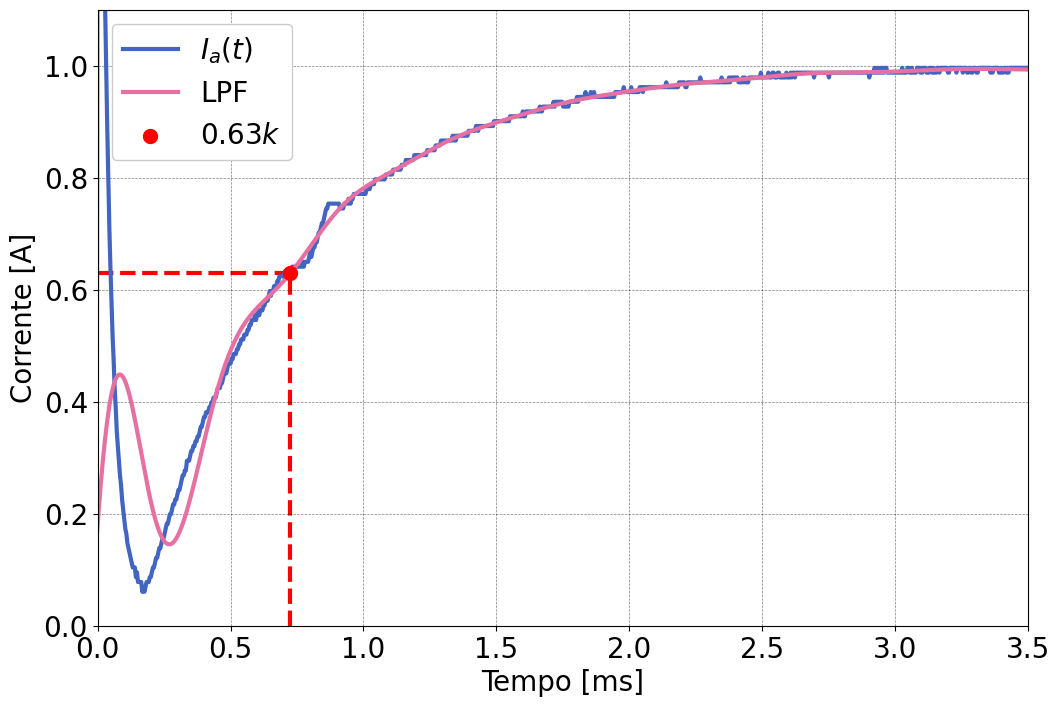

In [6]:
#Carregando curva do osciloscópio:
RB = np.loadtxt('RB\F0002CH1.csv', delimiter=',', unpack=True, dtype='str')
t1 = RB[3].astype(np.float_)[1240:2250]
y1 = RB[4].astype(np.float_)[1240:2250]
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da resistência de armadura:
Ra = (((vt/y1lpf[-1])-1)*Rs)
print(f'Ra = {Ra}')

#Ajuste da corrente pela queda de tensão no shunt:
y1 *= ((1/Ra)+(1/Rs))
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da constante de tempo elétrica:
y163 = 0.632*y1lpf[-1]
taue = t1[index(y1lpf[50:], y163)+50]
print(f'tau_e = {taue}')

#Cálculo da indutância de armadura:
La = taue*Ra
print(f'La = {La}')

#Plot dos dados:
plt.figure()
plt.plot((0, taue*1e3), (y163, y163), linestyle='dashed', color='r', zorder=0)
plt.plot((taue*1e3, taue*1e3), (0, y163), linestyle='dashed', color='r', zorder=0)
plt.plot(t1*1e3, y1, label='$I_a(t)$', zorder=1)
plt.plot(t1*1e3, y1lpf, label='LPF', zorder=2)
plt.scatter(taue*1e3, y163, color='r', linewidth=5, label='$0.63k$', zorder=3)
plt.ylim(0, 1.1)
plt.xlim(0, 3.5)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/rb.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$ \text{Ensaio a vazio (tensão nominal):}$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tau_m = 0.3679999999999999


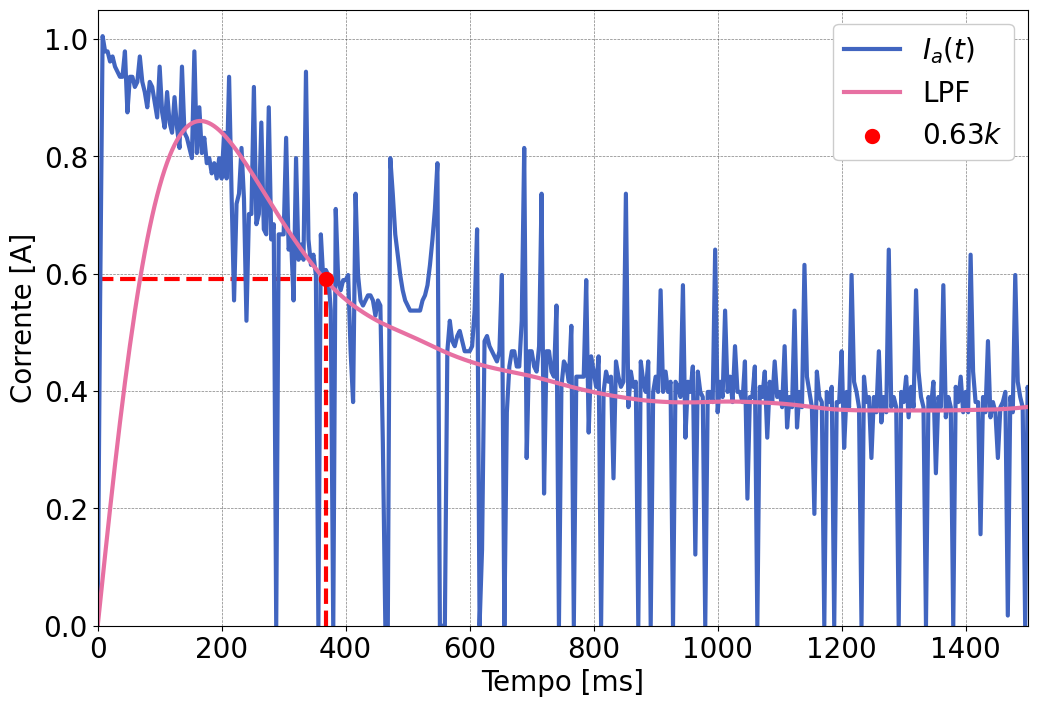

In [7]:
#Carregando curva do osciloscópio:
VZ = np.loadtxt('VZ\F0000CH1.csv', delimiter=',', unpack=True, dtype='str')
t2 = VZ[3].astype(np.float_)[320:1200]-VZ[3].astype(np.float_)[320]
y2 = VZ[4].astype(np.float_)[320:1200]
y2lpf = LPF(y2, 2, 10, 10e2)

#Ajuste da corrente pela queda de tensão no shunt:
y2 *= ((1/Ra)+(1/Rs))
y2lpf = LPF(y2, 2, 10, 10e2)

#Cálculo da constante de tempo mecânica:
y263 = (y2[2]-(0.632*(y2[2]-y2lpf[-1])))
taum = t2[index(y2lpf[30:], y263)+30]
print(f'tau_m = {taum}')

#Plot dos dados:
plt.figure()
plt.plot((0, taum*1e3), (y263, y263), linestyle='dashed', color='r', zorder=0)
plt.plot((taum*1e3, taum*1e3), (0, y263), linestyle='dashed', color='r', zorder=0)
plt.plot(t2*1e3, y2, label='$I_a(t)$', zorder=1)
plt.plot(t2*1e3, y2lpf, label='LPF', zorder=2)
plt.scatter(taum*1e3, y263, linewidths=5, color='r', label='$0.63k$', zorder=3)
plt.ylim(0, 1.05)
plt.xlim(0, 1.5*1e3)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/vz.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$ \text{Conferindo linearidade do motor:}$$

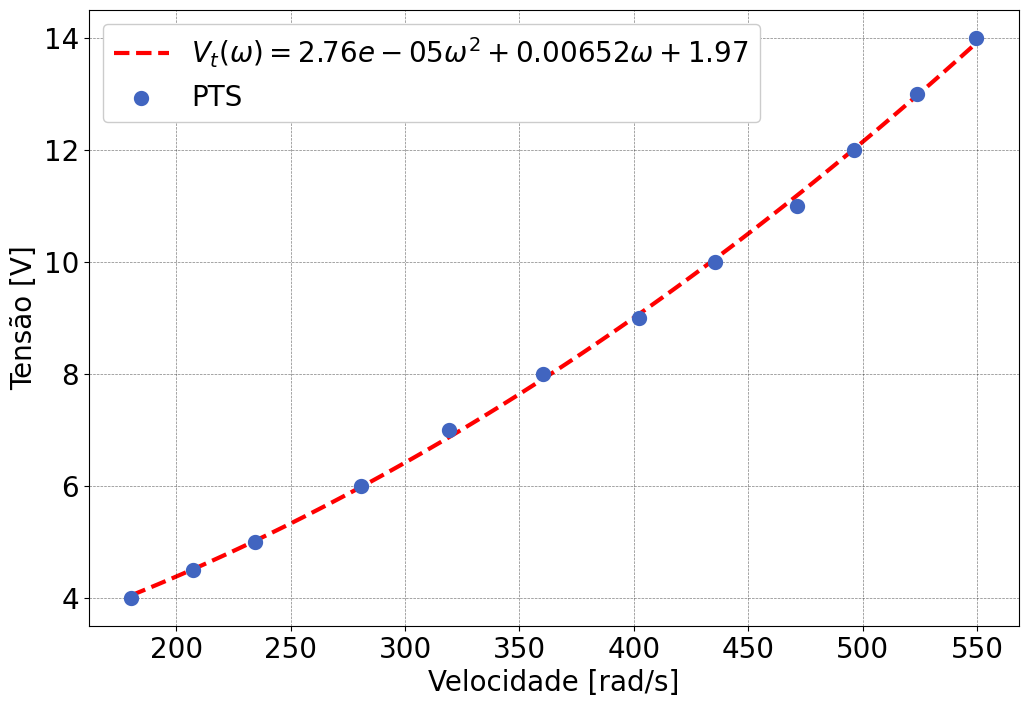

In [8]:
#Ajuste dos dados:
vmot = motpts[0][2:]
nmot = (motpts[2][2:]*2*np.pi/60)
nreg = np.linspace(nmot[0], nmot[-1], 100)
pol = np.polyfit(nmot, vmot, 2)
vreg = np.polyval(pol, nreg)

#Plot:
plt.figure()
plt.plot(nreg, vreg, linestyle='dashed', color='r', zorder=0, label=f'$V_t(\omega) = {round(pol[0],7)}\omega^2 + {round(pol[1],5)}\omega + {round(pol[2],2)}$')
plt.scatter(nmot, vmot, linewidth=5, zorder=1, label='PTS')
plt.ylabel('Tensão [V]')
plt.xlabel('Velocidade [rad/s]')
plt.legend()
plt.show()
#plt.savefig('curves/motwxv1.eps', dpi=600, transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


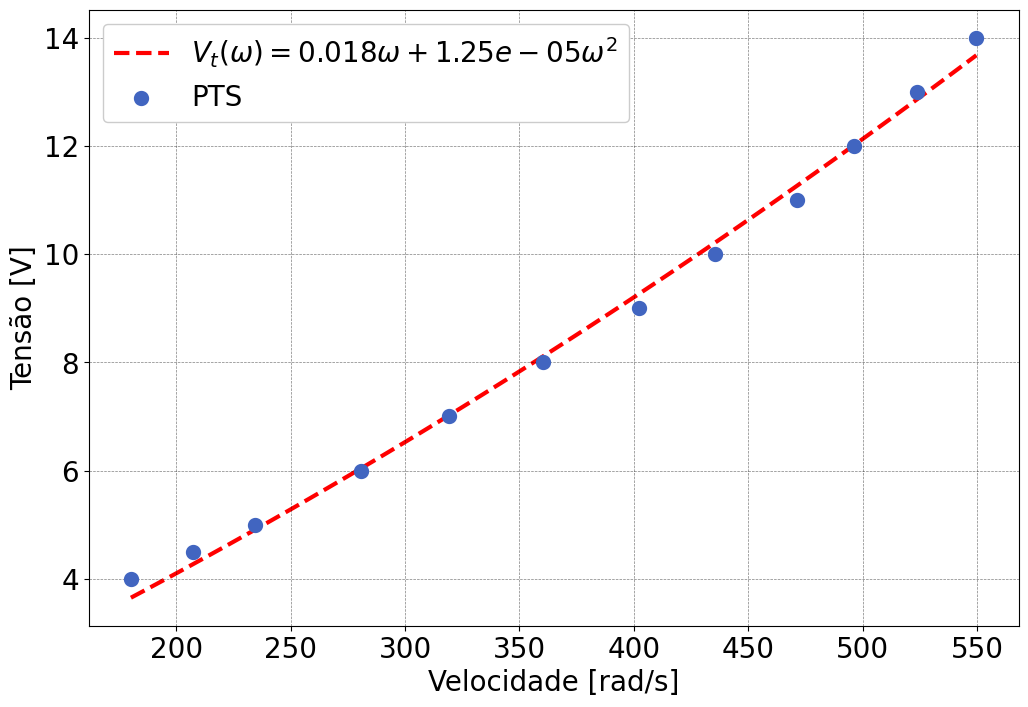

In [9]:
#Ajuste cúbico sem termo independente:
A = []
for w in nmot:
    A.append([w, w**2])
A = np.array(A)
B = np.array(vmot)[:, np.newaxis]
C = (np.linalg.inv(A.T@A)@A.T@B).T[0]

c1 = C[0]
c2 = C[1]

#Ajuste dos dados:
vadj = np.polyval(np.array([c2, c1, 0]), nreg)

#Plot:
plt.figure()
plt.plot(nreg, vadj, linestyle='dashed', color='r', zorder=0, label=f'$V_t(\omega) = {round(c1,4)}\omega + {round(c2,7)}\omega^2$')
plt.scatter(nmot, vmot,  linewidth=5, zorder=1, label='PTS')
plt.ylabel('Tensão [V]')
plt.xlabel('Velocidade [rad/s]')
plt.legend()
plt.savefig('curves/motwxv.eps', dpi=600, transparent=True, bbox_inches='tight')

In [10]:
#Cálulo da força contra-eletromotriz (para tensão nominal e a vazio):
vb = vt-Ra*y2lpf[-1]
print(f'Vb = {vb}')

#Cálculo da constante magnética e construtiva do motor (ponto de velocidade e tensão nominais):
kaphi = (vb/(4740*2*np.pi/60))
print(f'kaphi = {kaphi}')

#Cálculo da perda por ventilação e atrito no motor:
b1 = ((c1-kaphi)*kaphi/Ra)
b2 = (c2*kaphi/Ra)
print(f'b1 = {b1} \t b2 = {b2}')

#Cálculo do momento de inércia do motor:
Jm = taum*(b1+((kaphi**2)/Ra))
print(f'Jm = {Jm}')

Vb = 7.784515929495702
kaphi = 0.015682837845023306
b1 = 3.020510213671462e-06 	 b2 = 1.6259549029537842e-08
Jm = 8.619938225369939e-06


### $$ \text{Oscilação livre da placa:}$$

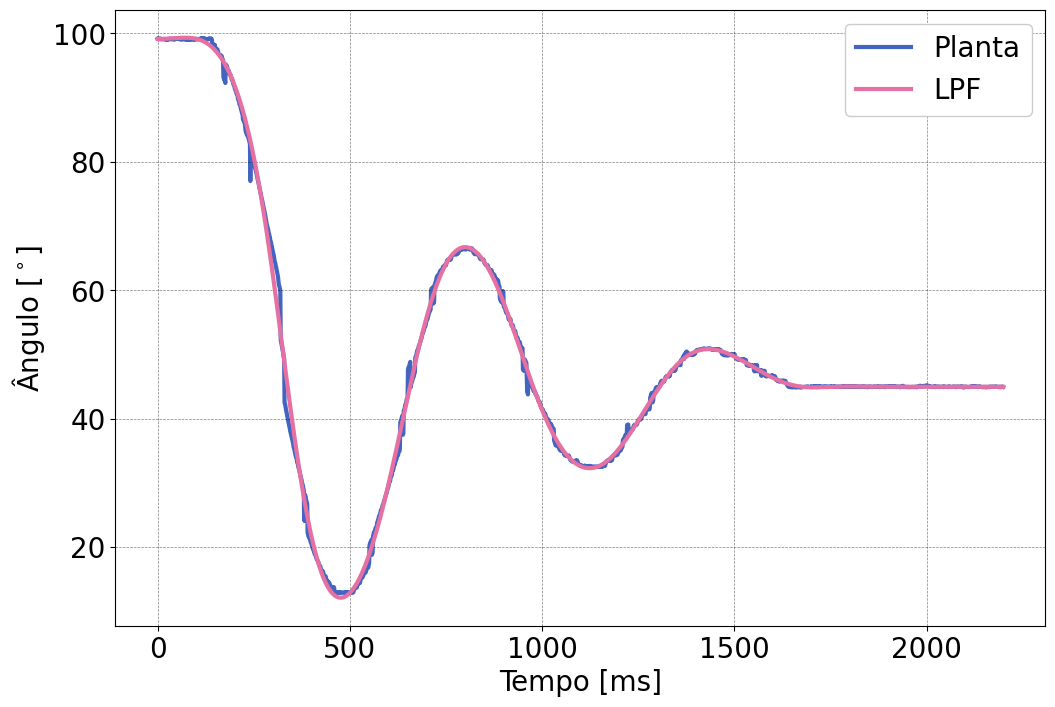

In [11]:
#Decupagem:
tosc = osc[0][800:3000]-osc[0][800]
angosc = osc[1][800:3000]
angosclpf = LPF(angosc, 4, 5, 1e3)

plt.figure()
plt.plot(tosc*1e3, angosc, label='Planta', zorder=0)
plt.plot(tosc*1e3, angosclpf, label='LPF', zorder=1)
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.show()
#plt.savefig('curves/freeosc1.eps', dpi=600, transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


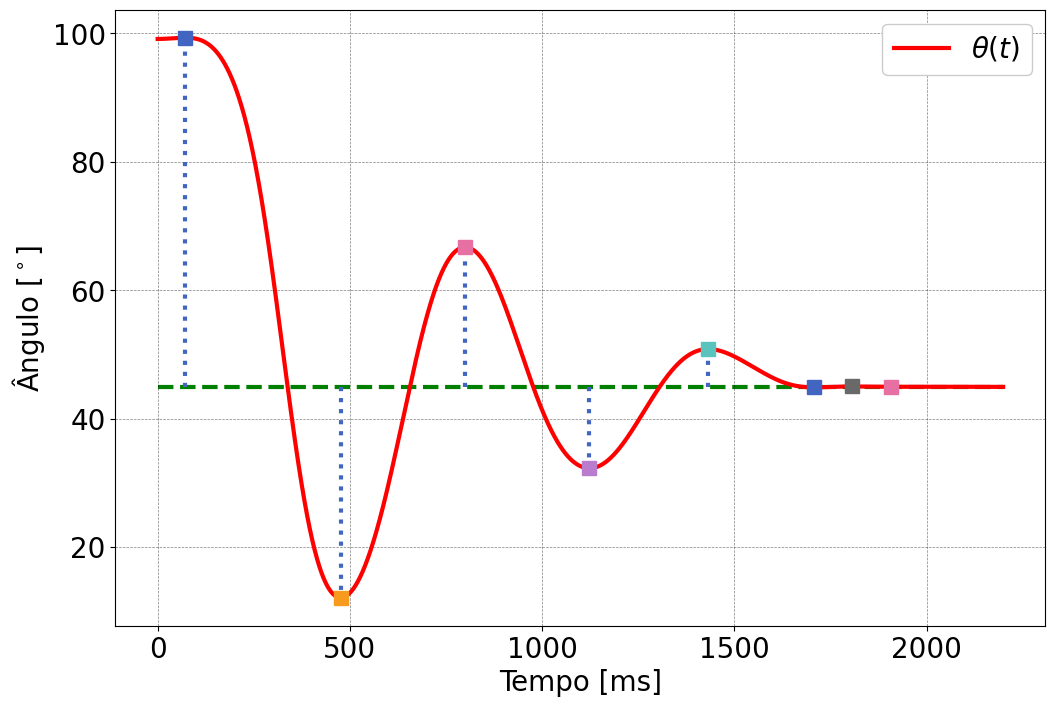

In [12]:
dang = np.gradient(angosclpf)

uperid = find_peaks(angosclpf)[0]
lowerid = find_peaks(-angosclpf)[0]

plt.figure()
plt.plot((tosc[0]*1e3, tosc[-1]*1e3), (45, 45), color='g', linestyle='dashed', zorder=0)
plt.plot(tosc*1e3, angosclpf, color='r', label='$\\theta(t)$', zorder=1)
for i in uperid[:4]:
    markerline, stemlines, baseline = plt.stem(tosc[i]*1e3, angosclpf[i], linefmt=':', bottom=45, markerfmt='s')
    markerline.set_markersize(10)
for i in lowerid[:4]:
    markerline, stemlines, baseline = plt.stem(tosc[i]*1e3, angosclpf[i], linefmt=':', bottom=45, markerfmt='s')
    markerline.set_markersize(10)
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/decaimento.eps', dpi=600, transparent=True, bbox_inches='tight')

T = 0.3272
bp2 = 0.015651594238411465 	 bp1 = 0.11437713295337787 	 bp0 = 0.011161051107795032


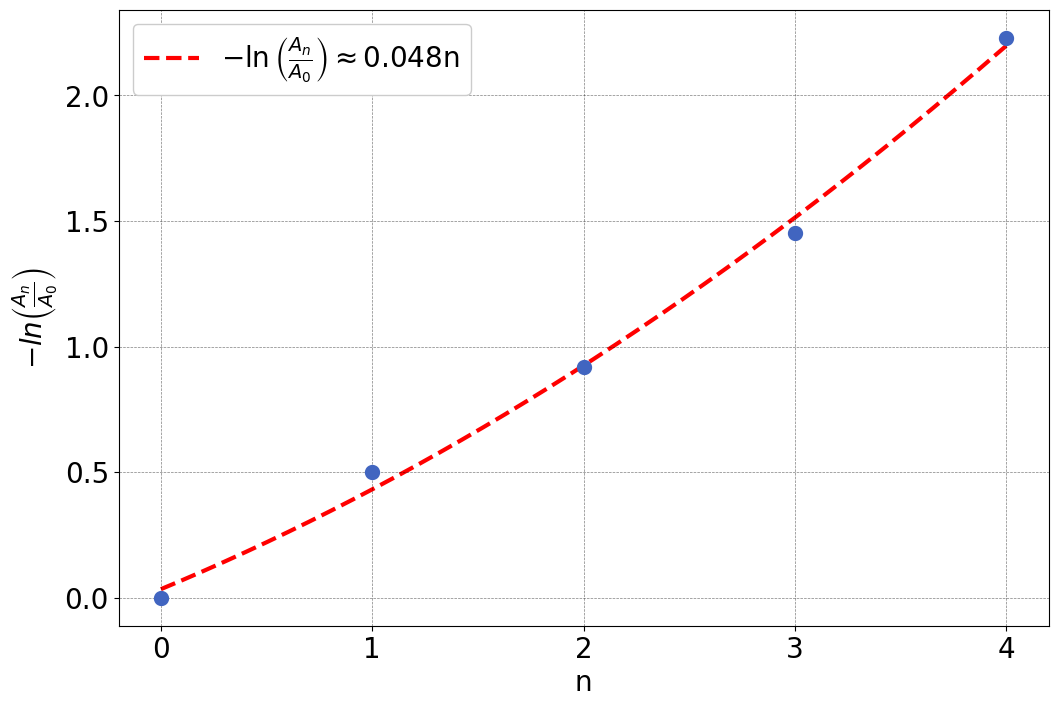

In [13]:
#Amplitudes absolutas dos picos e vales:
A = []
ta = []
for i in range(4):
    A.append(abs(angosclpf[uperid[i]]-45))
    ta.append(tosc[uperid[i]])
    A.append(abs(angosclpf[lowerid[i]]-45))
    ta.append(tosc[lowerid[i]])
A = np.array(A)
ta = np.array(ta)
A /= A[0]
A = A[:5]

#Cálculo do período médio de oscilação:
T = (tosc[lowerid[2]]-tosc[uperid[0]])/5
print(f'T = {T}')

#Ajuste linear para -ln(An/A0) X n, em que a inclinação será b/T:
pdec = np.polyfit(range(len(A)), -np.log(A), 2)
tadj = np.arange(0, 4, 1e-3)
Aadj = np.polyval(pdec, tadj)
bp2 = pdec[0]*T
bp1 = pdec[1]*T
bp0 = pdec[2]*T
print(f'bp2 = {bp2} \t bp1 = {bp1} \t bp0 = {bp0}')

#Plot:
plt.figure()
plt.plot(tadj, Aadj, linestyle='dashed', color='r', zorder=0, label='$-\ln \left( \\frac{A_n}{A_0} \\right) \\approx $'+f'{round(pdec[0], 3)}n')
plt.scatter(range(len(A)), -np.log(A), zorder=1, linewidths=5)
plt.ylabel('$-ln \left ( \\frac{A_n}{A_0} \\right )$')
plt.xlabel('n')
plt.xticks(range(len(A)))
plt.legend()
plt.show()
#plt.savefig('curves/freeosc3.eps', dpi=600, transparent=True, bbox_inches='tight')

In [14]:
#Cálculo do momento de inércia:
m = 0.072
g = 9.81
l = 0.068

tg = (m*g*l)

Jp = ((((-4*tg*bp1)+(T**2))/(8*tg))+((T*np.sqrt((-8*tg*bp1)+(T**2)))/(8*tg)))
print(f'Jp = {Jp}')

Jp = 0.4353686012905873


### $$ \text{Relação entre os sistemas:}$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


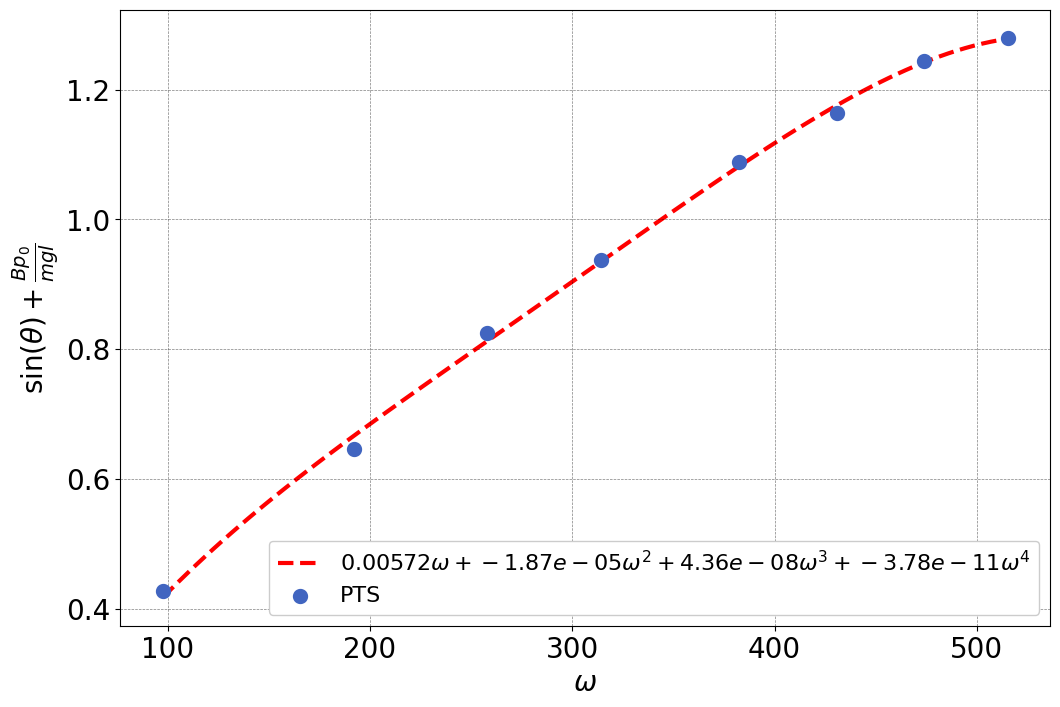

In [15]:
#Dados:
wmot = wxth[0]*2*np.pi/60
sinth = np.sin(np.radians(wxth[1]))+(0.0014*10/tg)

#Ajuste cúbico sem termo independente:
A = []
for w in wmot:
    A.append([w, w**2, w**3, w**4])
A = np.array(A)
B = np.array(sinth)[:, np.newaxis]
C = (np.linalg.inv(A.T@A)@A.T@B).T[0]

c1 = C[0]
c2 = C[1]
c3 = C[2]
c4 = C[3]


wlin = np.linspace(wmot[0], wmot[-1], 100)
sincalc = np.polyval(np.array([c4, c3, c2, c1, 0]), wlin)

#Plot:
plt.figure()
plt.plot(wlin, sincalc, linestyle='dashed', color='r', zorder=0, label=f'${round(c1,5)}\omega + {round(c2,8)}\omega^2 + {round(c3,10)}\omega^3 + {round(c4,13)}\omega^4$')
plt.scatter(wmot, sinth, zorder=1, linewidth=5, label='PTS')
plt.ylabel('$\sin(\\theta) + \\frac{Bp_0}{mgl}$')
plt.xlabel('$\omega$')
plt.legend(fontsize=16)
plt.savefig('curves/sysacop.eps', dpi=600, transparent=True, bbox_inches='tight')

In [16]:
#Ganho de acoplamento quadrático entre os sistemas:
ku1 = c1*tg
ku2 = c2*tg
ku3 = c3*tg
ku4 = c4*tg
print(f'ku1 = {ku1} \t ku2 = {ku2} \t ku3 = {ku3} \t ku4 = {ku4}')

ku1 = 0.00027489484856392873 	 ku2 = -8.982922212185895e-07 	 ku3 = 2.0931883912003e-09 	 ku4 = -1.8173114712122973e-12


### $$ \text{Conferindo linearidade do sistema completo:}$$

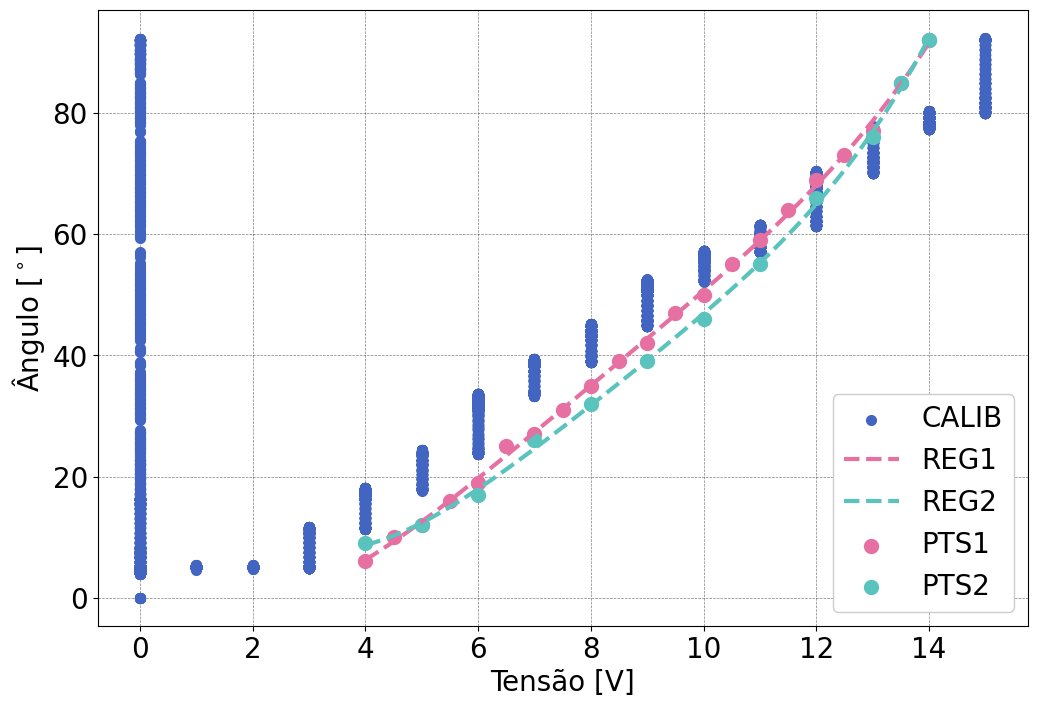

In [17]:
#Ajuste dos dados:
vin = syspts[0]
ang = syspts[1]
vreg = np.linspace(vin[0], vin[-1], 100)
angreg1 = np.polyval(np.polyfit(vin, ang, 4), vreg)
angreg2 = np.polyval(np.polyfit(syspts2[0], syspts2[1], 4), vreg)

#Plot:
plt.figure()
plt.scatter((calib[3]/100)*20, calib[1], linewidth=2, color='C0', label='CALIB')
plt.plot(vreg, angreg1, linestyle='dashed', color='C1', label='REG1')
plt.plot(vreg, angreg2, linestyle='dashed', color='C2', label='REG2')
plt.scatter(vin, ang, color='C1', linewidth=5, label='PTS1')
plt.scatter(syspts2[0], syspts2[1], color='C2', linewidth=5, label='PTS2')
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tensão [V]')
plt.legend()
plt.show()